In [1]:
import torch
from torchvision import datasets ,models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf # For downloading images
from PIL import Image

In [2]:
epochs = 100
batch_size_train = 32
batch_size_test = 32

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [3]:
# Download cats and dogs dataset
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('/content/cats_and_dogs.zip', origin=URL, extract=True)
!unzip '/content/cats_and_dogs.zip'

train_path = '/content/cats_and_dogs_filtered/train'
test_path = '/content/cats_and_dogs_filtered/validation'

68616192/68606236 [==============================] - 1s 0us/step
Archive:  /content/cats_and_dogs.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jp

(500, 374)


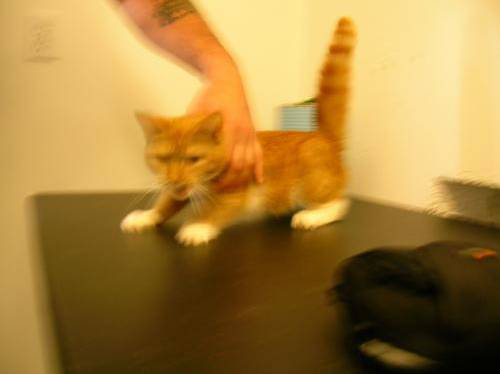

In [4]:
# Show image
img = Image.open('/content/cats_and_dogs_filtered/train/cats/cat.0.jpg')
print(img.size)
display(img)

In [5]:
image_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

In [6]:
train_data = datasets.ImageFolder(train_path, transform=image_transforms)
test_data = datasets.ImageFolder(test_path, transform=image_transforms)

In [7]:
print(train_data.class_to_idx)

{'cats': 0, 'dogs': 1}


In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [10]:
example_data.shape

torch.Size([32, 3, 256, 256])

In [11]:
def get_label(label):
  if label == 0:
    return "Cat"
  return "Dog"

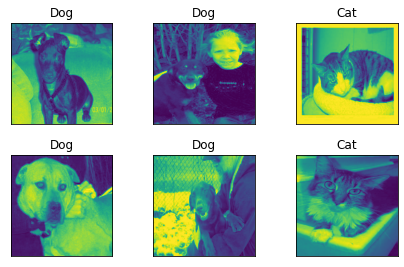

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0])
  plt.title("{}".format(get_label(example_targets[i])))
  plt.xticks([])
  plt.yticks([])

In [13]:
[list(train_data.class_to_idx.values()).index(0)]

[0]

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(32*32*128, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [15]:
network = Net()
network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=5e-6, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True, min_lr=1e-12)

In [16]:
train_losses = []
train_counter = []
test_accuracy = []
test_losses = []

In [17]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    pred = network(data)
    loss = F.binary_cross_entropy(pred.view(-1), target.float())
    loss.backward()
    optimizer.step()

  print('Train Epoch : {}, Loss : {:.6f}'.format(epoch, loss.item()))
  train_losses.append(loss.item())
  train_counter.append(epoch)

In [18]:
def test(epoch):
  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.cuda(), target.cuda()
      pred = network(data)
      pred = pred.view(-1)
      loss += F.binary_cross_entropy(pred, target.float(), reduction='sum').item()
      pred = torch.where(pred > 0.5, 1, 0)
      correct += torch.where(pred == target, 1, 0).sum()

  loss /= len(test_loader.dataset)
  scheduler.step(loss)

  print('\nTest Epoch : {}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    epoch, loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  test_losses.append(loss)
  test_accuracy.append((100 * correct / len(test_loader.dataset)).item())

In [19]:
for epoch in range(1, epochs+1):
  train(epoch)
  test(epoch)

Train Epoch : 1, Loss : 0.610477

Test Epoch : 1, Avg. loss: 0.6493, Accuracy: 616/1000 (62%)

Train Epoch : 2, Loss : 0.765035

Test Epoch : 2, Avg. loss: 0.6319, Accuracy: 630/1000 (63%)

Train Epoch : 3, Loss : 0.448071

Test Epoch : 3, Avg. loss: 0.6197, Accuracy: 633/1000 (63%)

Train Epoch : 4, Loss : 0.483313

Test Epoch : 4, Avg. loss: 0.5918, Accuracy: 688/1000 (69%)

Train Epoch : 5, Loss : 0.346133

Test Epoch : 5, Avg. loss: 0.6159, Accuracy: 661/1000 (66%)

Train Epoch : 6, Loss : 0.396527

Test Epoch : 6, Avg. loss: 0.6061, Accuracy: 659/1000 (66%)

Train Epoch : 7, Loss : 0.463332

Test Epoch : 7, Avg. loss: 0.5836, Accuracy: 672/1000 (67%)

Train Epoch : 8, Loss : 0.335762

Test Epoch : 8, Avg. loss: 0.5853, Accuracy: 688/1000 (69%)

Train Epoch : 9, Loss : 0.446645

Test Epoch : 9, Avg. loss: 0.5937, Accuracy: 668/1000 (67%)

Train Epoch : 10, Loss : 0.701139

Test Epoch : 10, Avg. loss: 0.6461, Accuracy: 641/1000 (64%)

Train Epoch : 11, Loss : 0.438839

Test Epoch : 

Text(0, 0.5, 'Loss')

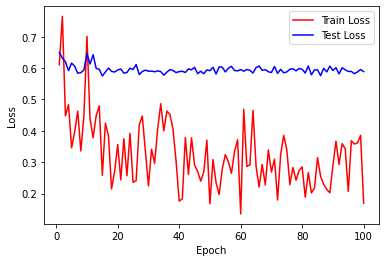

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='red')
plt.plot(train_counter, test_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

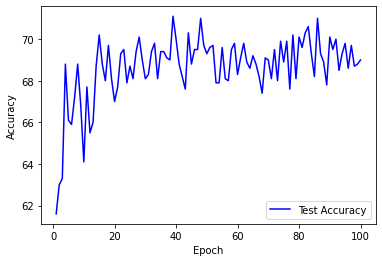

In [21]:
fig = plt.figure()
plt.plot(train_counter, test_accuracy, color='blue')
plt.legend(['Test Accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')